In [1]:
import random
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style('darkgrid')

In [2]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq

In [3]:
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [5]:
def make_window_ma(lower = 10, upper = 100):
    """
    Генерация размера скользящего окна, диапазоны указываем в аргументах
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

def make_observing_window(lower = 10, upper = 300):
    """
    Генерация окна наблюдения. То окно, которое будем использовать для обнаружения нестационарности.
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

In [6]:
def get_corr_coef(data, back_steps): #  шаг смещения >= 0
    """
    Calculate correlation coefficient
    :param data: numpy 1D array
    :param back_steps:  autocorrelation shift
    :return: correlation coefficient, float
    """

    return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

def make_autocorrelation_dependence(x, steps_max_part_window = 0.5):
    """
    It takes a numpy array, and the maximum number of steps to calculate the autocorrelation function. The number of steps is expressed in terms of a fraction of the window (the length of the received signal).
    :param x: numpy 1D array
    :param steps_max_part_window: fraction of the array window, default 0.5
    :return: numpy array
    """
    N = int(x.shape[0] * steps_max_part_window)
    steps = range(0, N + 1)
    coefs = [get_corr_coef(x, i) for i in steps]

    return np.array(coefs)

In [7]:
def make_random_signal(length, ma):
    """
    The function creates a smooth signal obtained from noise.
    :param length: size of creating signal
    :param ma: value of moving average window
    :return: nunpy array 1D
    """

    x = np.random.normal(0,1,max(length*2, ma * 2))
    x = pd.Series(x).rolling(window = ma).mean().dropna().values
    abs_x = np.abs(x)
    max_value =abs_x.max()
    x = x/max_value
    x = x[:length]

    return x

In [8]:
def calculate_hulving_time_acf(y, x = None):
    """
    Receive autocorrelation function and return the time it takes to halve
    :param y: numpy 1D array
    :param x: numpy 1D array, steps of shift. If None range(0, y.shape[0])
    :return: float
    """
    for i in range(y.shape[0]):
        if y[i] <= 0.5:
            break
    t2 = i
    t1 = i-1
    y1 = y[t1]
    y2 = y[t2]
    k = (t1 - t2) / (y1 - y2)
    b = t2 - k*y2
    t = k * 0.5 + b
    return t

In [9]:
def make_abs_spectr(signal, normalise = True):
    """
    Function receive numpy array signal, calculate abs FFT.
    If you want you may normalise it, as default
    :param signal: numpy array
    :param normalize: normalise [0,1]
    :return: numpy array FFT
    """
    signal_fft = np.abs(rfft(signal))
    if normalise:
        signal_fft = signal_fft / signal_fft.max()
    signal_fft = np.array(signal_fft)
    return signal_fft

In [10]:
def make_halving_bands(hulvings, window, std_coef):
    """
    Receive np array hulvings ACF.
    Return upper and lower band
    :param hulvings: numpy array
    :param window: Which wondow used to calculate halving
    :param std_coef: 1 sided size of band
    :return: Turple od 2 nimpy arrayus (lower_band, upper_band)
    """
    stats = [(np.mean(hulvings[i:i+window]),np.std(hulvings[i:i+window]))  for i in range(hulvings.shape[0] - window)]
    x_stats = range(window,len(hulvings))
    upper_band = [hulvings[i+window] + std_coef * stats[i][1] for i in range(len(stats))]
    lower_band = [stats[i][0] - std_coef * stats[i][1] for i in range(len(stats))]
    return lower_band, upper_band, x_stats

In [11]:
def make_halving_treshold(hulvings, window, delta_percent = 0):
    """
    Максимальное и минимальное знанчение являются пороговыми. Настраиваемый параметр - window - за какой период мы берем его.

    :param hulvings: numpy array
    :param window: Which wondow used to calculate halving
    :return: Turple od 2 numpy arrayus (lower_band, upper_band)
    """
    lower_band = []
    upper_band = []
    center = []
    x_stats = np.array(range(window, hulvings.shape[0]))
    for i in x_stats:
        row = hulvings[i-window:i]
        lower_band.append(row.min() - row.min() * delta_percent)
        upper_band.append(row.max() + row.max() * delta_percent)
        center.append((row.max() + row.min())/2)
    return np.array(center), np.array(lower_band), np.array(upper_band), x_stats

In [15]:
def find_halving_treshold_moments(center, lower_band, upper_band, window, hulvings):
    """
    Function finds time moments, when time hulving begin too much different, then earlier/
    The strategy is to look for the moment when the halving timeline of the autocorrelation function touches the upper or lower threshold. This will be the time when a new signal is detected. So that it does not signal constantly, the cancellation will be the touch of the central average from the two thresholds.
    :param center: mean (upper-lower) band, numpy array
    :param lower_band: upper treshold, numpy array
    :param upper_band: lower treshold, numpy array
    :param window: window, whisch used to calculcate hulving time, int
    :param hulvings: hulvings array,  numpy array
    :return: numpy array with time indices
    """
    results = []
    flag = 0     # При активном флаге мы отмечаем
    for i in range(window, hulvings.shape[0]):
        if not flag:
            if hulvings[i] > upper_band[i-window]:
                flag = 1
                results.append(i)
            if hulvings[i] < lower_band[i-window]:
                flag = -1
                results.append(i)
        if flag == 1:
            if hulvings[i] <= center[i - window]:
                flag = 0
        if flag == -1:
            if hulvings[i] >= center[i - window]:
                flag = 0
    results = np.array(results)
    return results

# Autocorrelation function observing

In [19]:
observe_window = 200
ma_window1 = 5
ma_window2 = 15
signal1 = make_random_signal(observe_window * 4, ma_window1)
signal2 = make_random_signal(observe_window * 4, ma_window2)
signal = np.concatenate([signal1, signal2])
signal_chunks = [signal[i:i+observe_window] for i in range(signal.shape[0]-observe_window-1)]
acf_chunks = [make_autocorrelation_dependence(i) for i in signal_chunks]
hulvings = [calculate_hulving_time_acf(i) for i in acf_chunks]
center, lower_band, upper_band, x_stats = make_halving_treshold(np.array(hulvings), window = 200, delta_percent=0.02)
find_halving_treshold_moments(center, lower_band, upper_band, observe_window, np.array(hulvings))

array([ 327,  676, 1214, 1332])

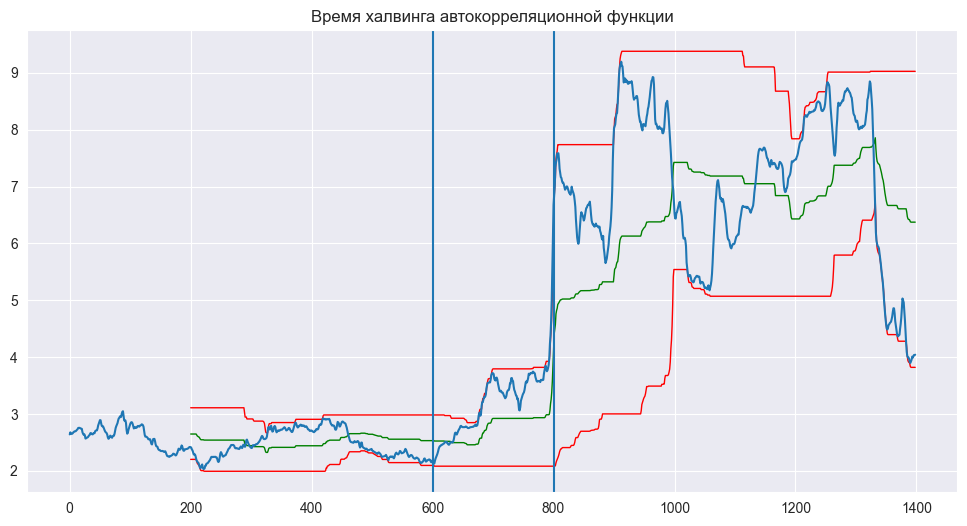

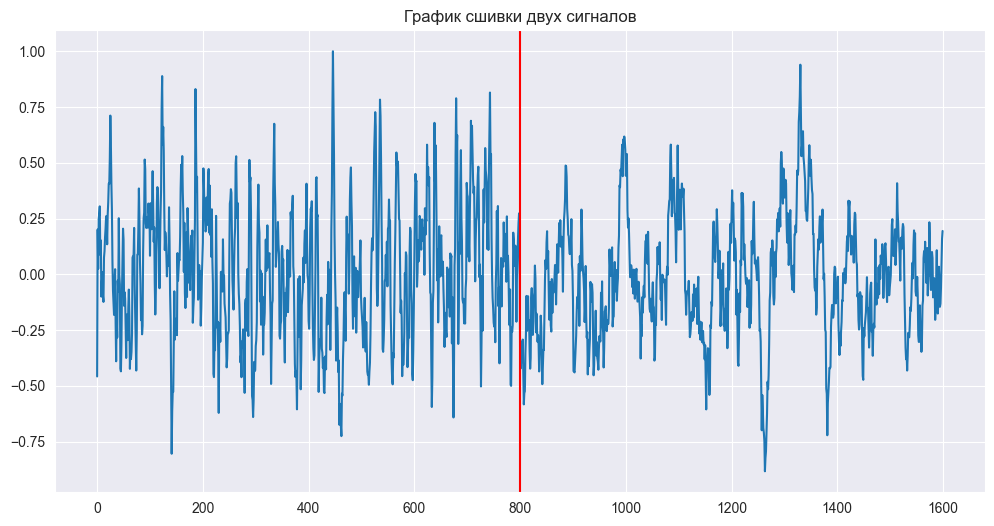

In [21]:
plt.figure(figsize = (12,6))

plt.plot(x_stats, upper_band, linewidth= 1, color = 'r',  label = 'upper')
plt.plot(x_stats, lower_band, linewidth= 1, color = 'r', label = 'lower')
plt.plot(x_stats, center, linewidth= 1, color = 'g',  label = 'center')
plt.plot(hulvings, label = 'hulvings')
plt.axvline(x=signal1.shape[0]-observe_window)
plt.axvline(x=signal1.shape[0])
plt.title("Время халвинга автокорреляционной функции")
plt.show()
plt.figure(figsize = (12,6))
plt.plot(signal)
plt.axvline(x=signal1.shape[0], color = 'r')
plt.title("График сшивки двух сигналов")
plt.show()